# <center> Майнор "Интеллектуальный анализ данных" </center>

# <center> Курс "Современные методы машинного обучения" </center>

# <center> Лабораторная работа №2. Object Detection. </center>

# Imports

In [1]:
!nvidia-smi

Sat Dec 18 19:04:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import glob
import cv2
from xml.etree import ElementTree as et
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches 
from sklearn.metrics import auc

In [3]:
import torchvision

In [4]:
from torchvision.models.detection.faster_rcnn import fasterrcnn_mobilenet_v3_large_320_fpn
from torchvision.models.detection.faster_rcnn import fasterrcnn_mobilenet_v3_large_fpn
from torchvision.models.detection.faster_rcnn import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

Install library for processing the labeling
```bash
pip install xmltodict
```

In [5]:
!pip install xmltodict

In [6]:
import xmltodict, json

# Data

В этом задании потребуется обучить детектор фруктов на изображении. Данные находятся в архиве `data.zip`. Данные уже поделены на train и test.

Датасет для трех классов.

In [7]:
class FruitImageDataset(torch.utils.data.Dataset):
    
    def __init__(self, data_dir: str, filter="/*.jpg", 
                 crop_width=224, crop_height=224, to_tensor=False,
                 classes=None, common_class=False, allow_no_target=False):
        self.files_dir = data_dir
        self.width = crop_width
        self.height = crop_height
        self.to_tensor = to_tensor
        
        if classes is None:
          self.classes_ = [_, 'apple', 'orange', 'banana']
        else:
          self.classes_ = classes
        self.common_class = common_class
        self.allow_no_target = allow_no_target
        
        self.images = glob.glob(self.files_dir + "/" + filter)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.files_dir, img_name)
        
        # Reading the image
        img = cv2.imread(img_path)
        
        # Defining width and height
        wt = img.shape[1]
        ht = img.shape[0]
        
        # Converting image to RGB channel and normalizing the image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img = cv2.resize(img, (self.width, self.height), cv2.INTER_AREA)
        img /= 255.0
        
        annot_name = img_name[:-4] + '.xml'
        annot_path = os.path.join(self.files_dir, annot_name)
        
        # Boxes to store the coordinate points of the bboxes
        boxes, labels = [], []
        
        if not os.path.exists(annot_path) and self.allow_no_target:
          if self.to_tensor:
            img = torch.Tensor(img)
            img = img.permute(2, 0, 1)
          return img, _

        tree = et.parse(annot_path)
        root = tree.getroot()
        
        # Box coordinates are extracted from the XML files for the given image size
        for member in root.findall('object'):
            label_name = member.find('name').text
            if self.common_class:
                labels.append(1)
            else:
                labels.append(self.classes_.index(label_name))
      
            xmin = float(member.find('bndbox').find('xmin').text)
            xmax = float(member.find('bndbox').find('xmax').text)
            ymin = float(member.find('bndbox').find('ymin').text)
            ymax = float(member.find('bndbox').find('ymax').text)
            
            x_min = (xmin/wt)*self.width
            x_max = (xmax/wt)*self.width
            y_min = (ymin/ht)*self.height
            y_max = (ymax/ht)*self.height
            
            boxes.append([x_min, y_min, x_max, y_max])
            
        # Conversion to Tensors   
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])  # Calculating area of the boxes
        
        iscrowd = torch.zeros((boxes.shape[0], ), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        image_id = torch.tensor([idx])
        
        target = {'boxes': boxes, 'area': area, 'labels': labels, 
                'iscrowd': iscrowd, 'image_id':image_id}

        if self.to_tensor:
          img = torch.Tensor(img)
          img = img.permute(2, 0, 1)
            
        return img, target

## Visualize

In [8]:
def plot_img_bbox(img, target, labels=None):
    if labels is not None:
      labels_ = labels
    else:
      labels_ = [_, "Apple", "Orange", "Banana"]
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()
    print("Detected objects:")
    for i, label in enumerate(target['labels']):
      if abs(int(label)) > len(labels_):
        cur_label = 'Undefined'
      else:
        cur_label = labels_[int(label)]
      print(f"{i + 1}) {cur_label}")

In [9]:
def visualize_prediction(img: torch.Tensor, target: dict, 
                         labels=None, filters=None):
    img_ = img.permute(1, 2, 0).numpy()
    target_ = target.copy()
    if filters is not None:
        for filter in filters:
            func, kargs = filter
            target_ = func(target_, **kargs)
    plot_img_bbox(img_, target_, labels)

## Prepare data

In [ ]:
# %cd /content/drive/MyDrive
# !unzip data.zip

In [ ]:
# !mkdir detection_data

In [ ]:
# !mv test_zip/test detection_data/test

In [ ]:
# !mv train_zip/train detection_data/train

In [ ]:
# !rmdir train_zip
# !rmdir test_zip

In [11]:
%cd /content

/content


In [10]:
DATASET_PATH = "/content/drive/My Drive/detection_data/"
CHECKPOINTS_PATH = "/content/drive/My Drive/detection_models"

In [13]:
print("Train size:", len(glob.glob(DATASET_PATH + "/train/*xml")))
print("Test size:", len(glob.glob(DATASET_PATH + "/test/*xml")))
print("Common size:", len(glob.glob(DATASET_PATH + "/*/*xml")))

Train size: 240
Test size: 60
Common size: 300


## Standart dataset example

In [11]:
fds = FruitImageDataset(DATASET_PATH, filter='//*/*.jpg')

In [12]:
print("[Image]\n", fds.__getitem__(0)[0].shape)
print("----------------")
print("[Target info]")
for key, value in fds.__getitem__(0)[1].items():
  print(f"{key} : ", value)

[Image]
 (224, 224, 3)
----------------
[Target info]
boxes :  tensor([[ 53.0133,  58.6900, 130.6667, 160.4192],
        [  8.9600,  21.5197,  78.4000, 108.5764],
        [100.0533,  22.4978, 181.4400, 112.4891],
        [ 79.8933, 123.2489, 161.2800, 224.0000],
        [154.5600, 134.9869, 222.5067, 224.0000]])
area :  tensor([7899.6167, 6045.2217, 7324.0889, 8199.7949, 6048.1440])
labels :  tensor([1, 1, 1, 1, 1])
iscrowd :  tensor([0, 0, 0, 0, 0])
image_id :  tensor([0])


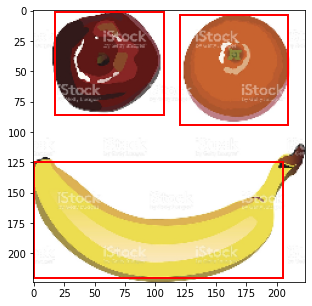

Detected objects:
1) Banana
2) Apple
3) Orange


In [13]:
image_array, target_info = fds.__getitem__(40)
plot_img_bbox(image_array, target_info)

## Common class (fruits) example

In [39]:
fds_all_fruits = FruitImageDataset(DATASET_PATH, filter='//*/*.jpg', common_class=True)

In [41]:
print("[Image]\n", fds_all_fruits.__getitem__(0)[0].shape)
print("----------------")
print("[Target info]")
for key, value in fds_all_fruits.__getitem__(0)[1].items():
  print(f"{key} : ", value)

[Image]
 (224, 224, 3)
----------------
[Target info]
boxes :  tensor([[ 53.0133,  58.6900, 130.6667, 160.4192],
        [  8.9600,  21.5197,  78.4000, 108.5764],
        [100.0533,  22.4978, 181.4400, 112.4891],
        [ 79.8933, 123.2489, 161.2800, 224.0000],
        [154.5600, 134.9869, 222.5067, 224.0000]])
area :  tensor([7899.6167, 6045.2217, 7324.0889, 8199.7949, 6048.1440])
labels :  tensor([4, 4, 4, 4, 4])
iscrowd :  tensor([0, 0, 0, 0, 0])
image_id :  tensor([0])


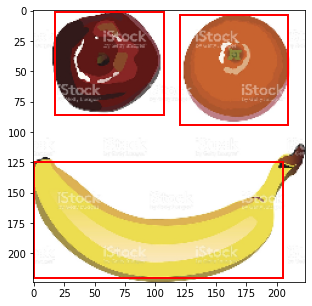

Detected objects:
1) Fruit
2) Fruit
3) Fruit


In [44]:
image_array, target_info = fds_all_fruits.__getitem__(40)
plot_img_bbox(image_array, target_info)

# Utilities

## Evaluate

In [17]:
def intersection_over_union(dt_bbox, gt_bbox):
    """
    Intersection over Union between two bboxes
    :param dt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :param gt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :return : intersection over union
    """

    intersection_bbox = np.array(
        [
            max(dt_bbox[0], gt_bbox[0]),
            max(dt_bbox[1], gt_bbox[1]),
            min(dt_bbox[2], gt_bbox[2]),
            min(dt_bbox[3], gt_bbox[3]),
        ]
    )

    intersection_area = max(intersection_bbox[2] - intersection_bbox[0], 0) * max(
        intersection_bbox[3] - intersection_bbox[1], 0
    )
    area_dt = (dt_bbox[2] - dt_bbox[0]) * (dt_bbox[3] - dt_bbox[1])
    area_gt = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])

    union_area = area_dt + area_gt - intersection_area

    iou = intersection_area / union_area
    return iou

def evaluate_sample(target_pred, target_true, iou_threshold=0.5):
    gt_bboxes = target_true["boxes"].numpy()
    gt_labels = target_true["labels"].numpy()

    dt_bboxes = target_pred["boxes"].numpy()
    dt_labels = target_pred["labels"].numpy()
    dt_scores = target_pred["scores"].numpy()

    results = []
    for detection_id in range(len(dt_labels)):
        dt_bbox = dt_bboxes[detection_id, :]
        dt_label = dt_labels[detection_id]
        dt_score = dt_scores[detection_id]

        detection_result_dict = {"score": dt_score}

        max_IoU = 0
        max_gt_id = -1
        for gt_id in range(len(gt_labels)):
            gt_bbox = gt_bboxes[gt_id, :]
            gt_label = gt_labels[gt_id]

            if gt_label != dt_label:
                continue

            if intersection_over_union(dt_bbox, gt_bbox) > max_IoU:
                max_IoU = intersection_over_union(dt_bbox, gt_bbox)
                max_gt_id = gt_id

        if max_gt_id >= 0 and max_IoU >= iou_threshold:
            detection_result_dict["TP"] = 1
            gt_labels = np.delete(gt_labels, max_gt_id, axis=0)
            gt_bboxes = np.delete(gt_bboxes, max_gt_id, axis=0)

        else:
            detection_result_dict["TP"] = 0

        results.append(detection_result_dict)

    return results


def evaluate(model, test_loader, device, iou_threshold=0.5, filters=None):
    results = []
    model.eval()
    nbr_boxes = 0
    with torch.no_grad():
        for batch, (images, targets_true) in enumerate(test_loader):
            images = list(image.to(device).float() for image in images)
            targets_pred = model(images)
            targets_true = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_true
            ]
            targets_pred = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_pred
            ]

            for i in range(len(targets_true)):
                target_true = targets_true[i]
                target_pred = targets_pred[i]

                if filters is not None:
                    for filter in filters:
                        func, kargs = filter
                        target_pred = func(target_pred, **kargs)

                nbr_boxes += target_true["labels"].shape[0]
                results.extend(evaluate_sample(target_pred, target_true, iou_threshold))

    results = sorted(results, key=lambda k: k["score"], reverse=True)

    acc_TP = np.zeros(len(results))
    acc_FP = np.zeros(len(results))
    recall = np.zeros(len(results))
    precision = np.zeros(len(results))

    if results[0]["TP"] == 1:
        acc_TP[0] = 1
    else:
        acc_FP[0] = 1

    for i in range(1, len(results)):
        acc_TP[i] = results[i]["TP"] + acc_TP[i - 1]
        acc_FP[i] = (1 - results[i]["TP"]) + acc_FP[i - 1]

        precision[i] = acc_TP[i] / (acc_TP[i] + acc_FP[i])
        recall[i] = acc_TP[i] / nbr_boxes

    return auc(recall, precision)

## Train

In [18]:
def train(model, optimizer, #criterion,
          train_loader, val_loader,
          epochs: int, report_step: int,
          checkpoint_path: str):
    device = "cpu" if not torch.cuda.is_available() else "cuda:0"
    iteration = 0
    for epoch in range(epochs):
        for i, data in enumerate(train_loader):
            model.train()

            images, targets = data
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            loss_dict = model(images, targets)

            # optimize
            losses = sum(loss for loss in loss_dict.values())
            losses.backward()
            optimizer.step()

            if iteration % report_step == 0:
                # validate
                eval_auc = evaluate(model, val_loader, device)
                print(f"[ Epoch: {epoch} | Iteration: {iteration} | Loss train: {losses.data} | Eval AUC: {eval_auc}]")
                # checkpoint
                torch.save({
                            'epoch': epoch,
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'loss': losses.data,
                            }, checkpoint_path)
            iteration += 1
    print("Finished Training")
    return

In [19]:
def collate_fn(batch):
    return tuple(zip(*batch))

## Prediction filters

In [54]:
def scores_filter(target: dict, threshold: 0.5):
    target_ = target.copy()

    index = 0
    while index < len(target_['scores']):
      cur_score = target_['scores'][index]
      if cur_score <= threshold:
        break
      index += 1

    target_['scores'] = target_['scores'][: index]
    target_['boxes'] = target_['boxes'][: index]
    target_['labels'] = target_['labels'][: index]
    return target_

In [16]:
def nms(target: dict, threshold=0.1):
    nms_indexes = torchvision.ops.nms(target['boxes'], target['scores'], threshold)
    target_ = target.copy()
    target_['boxes'] = target_['boxes'][nms_indexes]
    target_['scores'] = target_['scores'][nms_indexes]
    target_['labels'] = target_['labels'][nms_indexes]
    return target_

# Test inference

For the start, just try to use original model that predicts 91 classes (our fruits are in this list)

In [96]:
frcnn_model = fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True, pretrained_backbone=True)

In [97]:
device = "cpu" if not torch.cuda.is_available() else "cuda:0"
_ = frcnn_model.to(device)

In [104]:
test_dataset = FruitImageDataset(DATASET_PATH, '/test/*.jpg', 
                                 common_class=True, to_tensor=True)
len(test_dataset)

60

In [105]:
batch_size = 16
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False,
                                          collate_fn=collate_fn)

In [121]:
test_image, test_target = test_dataset[0]
frcnn_model.eval()
with torch.no_grad():
  prediction = frcnn_model([test_image.to(device)])[0]
prediction

{'boxes': tensor([[ 47.6871,  62.9995, 137.1193, 158.0821],
         [ 84.4411, 127.0406, 164.8629, 214.5136],
         [156.3432, 147.3688, 224.0000, 222.8624],
         [115.7563,  70.1987, 170.9091, 117.7448],
         [ 44.5871,  59.1047, 194.5620, 207.2488],
         [  8.1389,  26.3753,  71.2723, 101.7830],
         [127.6275, 116.6005, 160.7272, 147.4132],
         [148.9960,  26.5356, 180.4370,  64.1004],
         [120.3471,  52.1382, 186.2907, 112.7408],
         [ 80.7051,  61.8931, 175.4066, 132.6568],
         [141.4898,  66.7635, 191.0385, 103.5744],
         [176.4431, 144.7061, 209.1934, 165.5116],
         [136.4281,  58.9711, 180.0951,  95.3132],
         [141.3763,  70.8751, 173.9527,  98.2373],
         [160.3121, 121.6510, 194.4635, 153.4486]]),
 'labels': tensor([53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53]),
 'scores': tensor([0.8683, 0.8257, 0.8202, 0.4876, 0.4453, 0.4204, 0.2368, 0.2125, 0.1795,
         0.1095, 0.1017, 0.0840, 0.0781, 0.0610, 0.0

Predicted model found many **53** labels, that are **"Apple"**s in the COCO train2017  
Let's visualize only those with signinficant scores

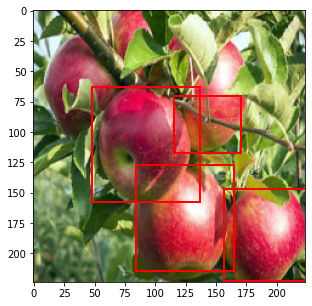

Detected objects:
1) Undefined
2) Undefined
3) Undefined
4) Undefined


In [126]:
scores_threshold = 0.5
filters = [(scores_filter, {"threshold" : scores_threshold})]
visualize_prediction(test_image, prediction, filters=filters)

**Note**: Undefined just becuase I described another labels in my visualizer function

# Part1

## Task1

Now I change the predictor

In [128]:
num_classes = 2

In [132]:
frcnn_model = fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True, pretrained_backbone=True)
prediction_features = frcnn_model.roi_heads.box_predictor.cls_score.in_features
frcnn_model.roi_heads.box_predictor = FastRCNNPredictor(prediction_features, num_classes)

In [133]:
device = "cpu" if not torch.cuda.is_available() else "cuda:0"
_ = frcnn_model.to(device)

In [140]:
test_dataset = FruitImageDataset(DATASET_PATH, '/test/*.jpg', 
                                 common_class=True, to_tensor=True)
len(test_dataset)

60

In [141]:
batch_size = 16
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False,
                                          collate_fn=collate_fn)

Evaluate results

In [160]:
evaluate(frcnn_model, test_loader, device, iou_threshold=0.5)

0.23255818701880204

In [147]:
test_image, test_target = test_dataset[0]
frcnn_model.eval()
with torch.no_grad():
  prediction = frcnn_model([test_image.to(device)])[0]
prediction['scores']

tensor([0.7864, 0.7619, 0.7497, 0.7303, 0.7223, 0.7148, 0.7073, 0.7066, 0.6988,
        0.6887, 0.6817, 0.6785, 0.6743, 0.6715, 0.6701, 0.6697, 0.6665, 0.6639,
        0.6568, 0.6524, 0.6480, 0.6459, 0.6421, 0.6409, 0.6306, 0.6270, 0.6269,
        0.6192, 0.6154, 0.6134, 0.6130, 0.6027, 0.5976, 0.5975, 0.5964, 0.5956,
        0.5882, 0.5821, 0.5816, 0.5778, 0.5748, 0.5676, 0.5633, 0.5628, 0.5570,
        0.5243, 0.5120, 0.4730, 0.4564])

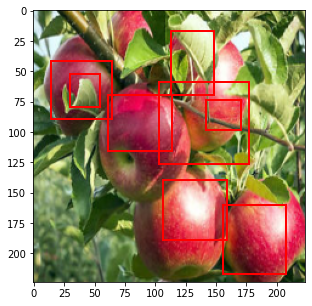

Detected objects:
1) Fruit
2) Fruit
3) Fruit
4) Fruit
5) Fruit
6) Fruit
7) Fruit
8) Fruit


In [153]:
visualize_prediction(test_image, prediction, 0.7, labels=[_, "Fruit"])

## Task2

### Data

In [24]:
train_dataset = FruitImageDataset(DATASET_PATH, '/train/*.jpg', 
                                  common_class=True, to_tensor=True)

test_dataset = FruitImageDataset(DATASET_PATH, '/test/*.jpg', 
                                 common_class=True, to_tensor=True)

train_size = int(len(train_dataset) * train_split_precent)
train_subset, val_subset = random_split(train_dataset, 
                                        [train_size, len(train_dataset) - train_size],
                                        generator=torch.Generator().manual_seed(13))
print(f"Train: {len(train_subset)} | Validation: {len(val_subset)}")

Train: 192 | Validation: 48


In [25]:
batch_size = 16
train_loader = torch.utils.data.DataLoader(train_subset, 
                                           batch_size=batch_size, 
                                           shuffle=False,
                                           collate_fn=collate_fn)

val_loader = torch.utils.data.DataLoader(val_subset, 
                                         batch_size=batch_size, 
                                         shuffle=False,
                                         collate_fn=collate_fn)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False,
                                          collate_fn=collate_fn)

### Unpretrained

In [20]:
num_classes = 2
train_split_precent = 0.8
pretrained = False

Model

In [21]:
frcnn_model_unpretrained = fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=pretrained, pretrained_backbone=True)
prediction_features = frcnn_model_unpretrained.roi_heads.box_predictor.cls_score.in_features
frcnn_model_unpretrained.roi_heads.box_predictor = FastRCNNPredictor(prediction_features, num_classes)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


  0%|          | 0.00/21.1M [00:00<?, ?B/s]

In [22]:
device = "cpu" if not torch.cuda.is_available() else "cuda:0"
_ = frcnn_model_unpretrained.to(device)

In [23]:
device

'cuda:0'

Train

In [27]:
epochs = 10
report_step = 6
params = [p for p in frcnn_model_unpretrained.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.005)

In [28]:
train(frcnn_model_unpretrained, optimizer,
      train_loader, val_loader,
      epochs, report_step,
      checkpoint_path=CHECKPOINTS_PATH + "/fast_rcnn_1_class_unpretrained")

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[ Epoch: 0 | Iteration: 0 | Loss train: 1.594264030456543 | Eval AUC: 0.007759715380281336]
[ Epoch: 0 | Iteration: 6 | Loss train: 1.3043668270111084 | Eval AUC: 0.0005933426554294153]
[ Epoch: 1 | Iteration: 12 | Loss train: 1.1559895277023315 | Eval AUC: 0.030492640445479516]
[ Epoch: 1 | Iteration: 18 | Loss train: 1.0802775621414185 | Eval AUC: 0.23103270400036346]
[ Epoch: 2 | Iteration: 24 | Loss train: 0.9358596205711365 | Eval AUC: 0.29682386004442995]
[ Epoch: 2 | Iteration: 30 | Loss train: 0.7008547782897949 | Eval AUC: 0.3500009537229093]
[ Epoch: 3 | Iteration: 36 | Loss train: 0.4859013557434082 | Eval AUC: 0.37979949732100754]
[ Epoch: 3 | Iteration: 42 | Loss train: 0.5246875286102295 | Eval AUC: 0.35407518001538624]
[ Epoch: 4 | Iteration: 48 | Loss train: 0.4784354567527771 | Eval AUC: 0.5870599222722385]
[ Epoch: 4 | Iteration: 54 | Loss train: 0.4666980803012848 | Eval AUC: 0.5959112655275576]
[ Epoch: 5 | Iteration: 60 | Loss train: 0.46626701951026917 | Eval AUC:

Evaluation results

In [29]:
evaluate(frcnn_model_unpretrained, test_loader, device)

0.7533591378344493

### Pretrained

In [30]:
num_classes = 2
train_split_precent = 0.8
pretrained = True

Model

In [35]:
frcnn_model_pretrained = fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=pretrained, pretrained_backbone=True)
prediction_features = frcnn_model_pretrained.roi_heads.box_predictor.cls_score.in_features
frcnn_model_pretrained.roi_heads.box_predictor = FastRCNNPredictor(prediction_features, num_classes)

In [36]:
device = "cpu" if not torch.cuda.is_available() else "cuda:0"
_ = frcnn_model_pretrained.to(device)

In [37]:
device

'cuda:0'

Train

In [39]:
epochs = 10
report_step = 6
params = [p for p in frcnn_model_pretrained.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.005)

In [40]:
train(frcnn_model_pretrained, optimizer,
      train_loader, val_loader,
      epochs, report_step,
      checkpoint_path=CHECKPOINTS_PATH + "/fast_rcnn_1_class_pretrained")

[ Epoch: 0 | Iteration: 0 | Loss train: 1.9817832708358765 | Eval AUC: 0.21540941451765858]
[ Epoch: 0 | Iteration: 6 | Loss train: 1.3993531465530396 | Eval AUC: 0.812223466010079]
[ Epoch: 1 | Iteration: 12 | Loss train: 1.1359190940856934 | Eval AUC: 0.8545112451447501]
[ Epoch: 1 | Iteration: 18 | Loss train: 0.8824623227119446 | Eval AUC: 0.8371638523987636]
[ Epoch: 2 | Iteration: 24 | Loss train: 0.9099512100219727 | Eval AUC: 0.8660313192037422]
[ Epoch: 2 | Iteration: 30 | Loss train: 1.0050641298294067 | Eval AUC: 0.9063073886388893]
[ Epoch: 3 | Iteration: 36 | Loss train: 0.9142304062843323 | Eval AUC: 0.9062793332124164]
[ Epoch: 3 | Iteration: 42 | Loss train: 0.9684852957725525 | Eval AUC: 0.885521893920196]
[ Epoch: 4 | Iteration: 48 | Loss train: 0.7096489667892456 | Eval AUC: 0.9231778113772942]
[ Epoch: 4 | Iteration: 54 | Loss train: 0.7474597692489624 | Eval AUC: 0.9131906157429455]
[ Epoch: 5 | Iteration: 60 | Loss train: 0.738122284412384 | Eval AUC: 0.9082919669

In [41]:
evaluate(frcnn_model_pretrained, test_loader, device)

0.868261820740159

## Task3 + Task4

### IoU Threshold

In [42]:
evaluate(frcnn_model_pretrained, test_loader, device, iou_threshold=0.4)

0.8844583160469132

In [44]:
evaluate(frcnn_model_pretrained, test_loader, device, iou_threshold=0.1)

0.8938518480425545

In [43]:
evaluate(frcnn_model_pretrained, test_loader, device, iou_threshold=0.6)

0.7695202907981814

**Conclusion**:  
*less* iou_threshold -> *higher* metric  

---

However, we should not **trust** the results with low iou_threshold

### Scores filtering

In [56]:
scores_threshold = 0.0 # standart
filters = [(scores_filter, {"threshold" : scores_threshold})]
evaluate(frcnn_model_pretrained, test_loader, device, iou_threshold=0.5, filters=filters)

0.868261820740159

In [57]:
scores_threshold = 0.5
filters = [(scores_filter, {"threshold" : scores_threshold})]
evaluate(frcnn_model_pretrained, test_loader, device, iou_threshold=0.5, filters=filters)

0.8104066864483477

In [58]:
scores_threshold = 0.3
filters = [(scores_filter, {"threshold" : scores_threshold})]
evaluate(frcnn_model_pretrained, test_loader, device, iou_threshold=0.5, filters=filters)

0.8397570658262253

In [59]:
scores_threshold = 0.7
filters = [(scores_filter, {"threshold" : scores_threshold})]
evaluate(frcnn_model_pretrained, test_loader, device, iou_threshold=0.5, filters=filters)

0.7725670836593158

**Conclusion**:  
metrics show, that **limiting** the confidence score leads to **worse metrics** :( 

---

**BUT!!!** Let's try to visualize

### Visualization

In [62]:
test_image, test_target = test_dataset[0]
frcnn_model_pretrained.eval()
with torch.no_grad():
  prediction = frcnn_model_pretrained([test_image.to(device)])[0]
prediction['scores']

tensor([0.9914, 0.9879, 0.9764, 0.9693, 0.6865, 0.0549], device='cuda:0')

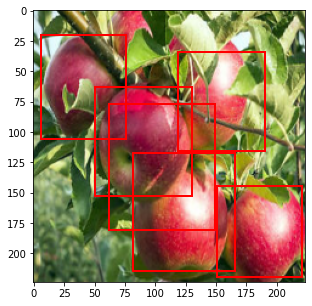

Detected objects:
1) Fruit
2) Fruit
3) Fruit
4) Fruit
5) Fruit
6) Fruit


In [65]:
scores_threshold = 0.0
filters = [(scores_filter, {"threshold" : scores_threshold})]
visualize_prediction(test_image, prediction,
                     filters=filters, labels=[_, "Fruit"])

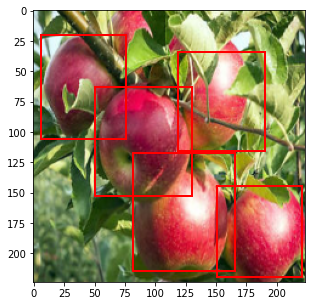

Detected objects:
1) Fruit
2) Fruit
3) Fruit
4) Fruit
5) Fruit


In [67]:
scores_threshold = 0.5
filters = [(scores_filter, {"threshold" : scores_threshold})]
visualize_prediction(test_image, prediction,
                     filters=filters, labels=[_, "Fruit"])

We can see, that scores filtering helped to exclude **excess frame** in the middle  
This frame doesn't have signinficant influence on metrics, but it detects non-existent object  

In [85]:
test_image, test_target = test_dataset[59]
frcnn_model_pretrained.eval()
with torch.no_grad():
  prediction = frcnn_model_pretrained([test_image.to(device)])[0]
prediction['scores']

tensor([0.9823, 0.9817, 0.2683], device='cuda:0')

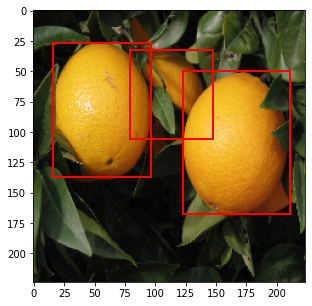

Detected objects:
1) Fruit
2) Fruit
3) Fruit


In [86]:
scores_threshold = 0.0
filters = [(scores_filter, {"threshold" : scores_threshold})]
visualize_prediction(test_image, prediction,
                     filters=filters, labels=[_, "Fruit"])

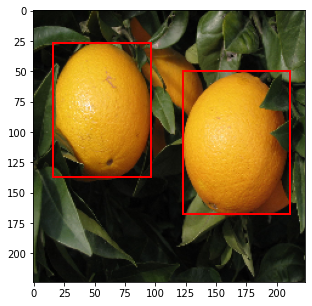

Detected objects:
1) Fruit
2) Fruit


In [87]:
scores_threshold = 0.5
filters = [(scores_filter, {"threshold" : scores_threshold})]
visualize_prediction(test_image, prediction,
                     filters=filters, labels=[_, "Fruit"])

In this situation we filtered well detected lemon by 0.5 threshold  
Bad result


---

**Conclusion**: for better real results we should set score filtering with low threshold

In [88]:
scores_threshold = 0.2
filters = [(scores_filter, {"threshold" : scores_threshold})]
evaluate(frcnn_model_pretrained, test_loader, device, iou_threshold=0.5, filters=filters)

0.8611896128190338

### Pictures from the Internet

In [97]:
labels = [_, "Fruit"]

In [98]:
internet_dataset = FruitImageDataset(DATASET_PATH, filter="/internet/*.jpg", 
                                     to_tensor=True, 
                                     classes=labels, common_class=True,
                                     allow_no_target=True)

In [99]:
test_image, _ = internet_dataset[0]
frcnn_model_pretrained.eval()
with torch.no_grad():
  prediction = frcnn_model_pretrained([test_image.to(device)])[0]
prediction['scores']

tensor([0.8877, 0.4344], device='cuda:0')

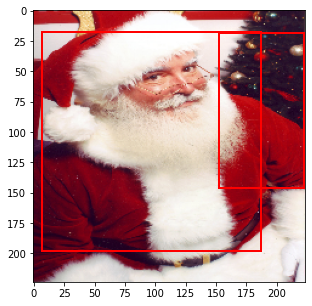

Detected objects:
1) Fruit
2) Fruit


In [100]:
visualize_prediction(test_image, prediction,
                     filters=filters, labels=labels)

In [101]:
test_image, _ = internet_dataset[1]
frcnn_model_pretrained.eval()
with torch.no_grad():
  prediction = frcnn_model_pretrained([test_image.to(device)])[0]
prediction['scores']

tensor([0.9957, 0.9643, 0.9388, 0.9339, 0.8932, 0.8125, 0.7928, 0.7507, 0.7366,
        0.4976, 0.2981, 0.2762, 0.1724, 0.1284, 0.0626], device='cuda:0')

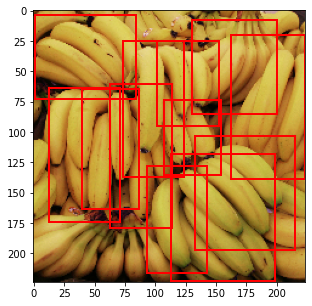

Detected objects:
1) Fruit
2) Fruit
3) Fruit
4) Fruit
5) Fruit
6) Fruit
7) Fruit
8) Fruit
9) Fruit
10) Fruit
11) Fruit
12) Fruit


In [102]:
visualize_prediction(test_image, prediction,
                     filters=filters, labels=labels)

In [103]:
test_image, _ = internet_dataset[2]
frcnn_model_pretrained.eval()
with torch.no_grad():
  prediction = frcnn_model_pretrained([test_image.to(device)])[0]
prediction['scores']

tensor([0.9741], device='cuda:0')

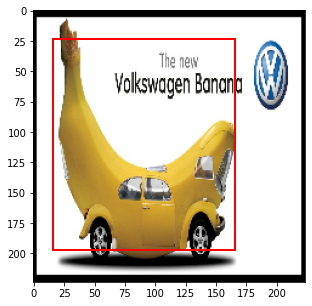

Detected objects:
1) Fruit


In [104]:
visualize_prediction(test_image, prediction,
                     filters=filters, labels=labels)

)))))))))

In [105]:
test_image, _ = internet_dataset[3]
frcnn_model_pretrained.eval()
with torch.no_grad():
  prediction = frcnn_model_pretrained([test_image.to(device)])[0]
prediction['scores']

tensor([0.9925], device='cuda:0')

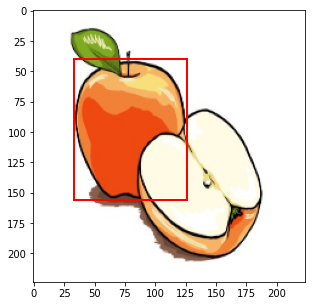

Detected objects:
1) Fruit


In [106]:
visualize_prediction(test_image, prediction,
                     filters=filters, labels=labels)

Model detects fruits on a good level  
Even inside Santa's stomach

## Task5

In [110]:
scores_threshold = 0.2
nms_threshold = 0.1

filters = [(scores_filter, {"threshold" : scores_threshold}),
           (nms,           {"threshold" : nms_threshold})]
evaluate(frcnn_model_pretrained, test_loader, device, 
         iou_threshold=nms_threshold, filters=filters)

0.6910433502584113

In [118]:
scores_threshold = 0.2
nms_threshold = 0.3

filters = [(scores_filter, {"threshold" : scores_threshold}),
           (nms,           {"threshold" : nms_threshold})]
evaluate(frcnn_model_pretrained, test_loader, device, filters=filters)

0.8093207573694073

In [119]:
test_image, test_target = test_dataset[0]
frcnn_model_pretrained.eval()
with torch.no_grad():
  prediction = frcnn_model_pretrained([test_image.to(device)])[0]
prediction['scores']

tensor([0.9914, 0.9879, 0.9764, 0.9693, 0.6865, 0.0549], device='cuda:0')

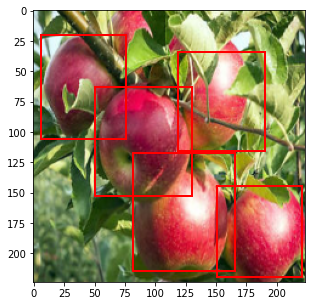

Detected objects:
1) Fruit
2) Fruit
3) Fruit
4) Fruit
5) Fruit


In [122]:
nms_threshold = 0.3

filters = [(nms, {"threshold" : nms_threshold})]

visualize_prediction(test_image, prediction,
                     filters=filters, labels=[_, "Fruit"])

In [123]:
test_image, _ = internet_dataset[1]
frcnn_model_pretrained.eval()
with torch.no_grad():
  prediction = frcnn_model_pretrained([test_image.to(device)])[0]
prediction['scores']

tensor([0.9957, 0.9643, 0.9388, 0.9339, 0.8932, 0.8125, 0.7928, 0.7507, 0.7366,
        0.4976, 0.2981, 0.2762, 0.1724, 0.1284, 0.0626], device='cuda:0')

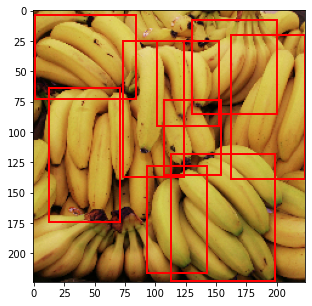

Detected objects:
1) Fruit
2) Fruit
3) Fruit
4) Fruit
5) Fruit
6) Fruit
7) Fruit
8) Fruit
9) Fruit


In [124]:
nms_threshold = 0.3

filters = [(nms, {"threshold" : nms_threshold})]

visualize_prediction(test_image, prediction,
                     filters=filters, labels=[_, "Fruit"])

Despite the decrease in metrics, real results shows improvements

# Part2

## Task1

In [125]:
num_classes = 4

In [126]:
frcnn_model = fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True, pretrained_backbone=True)
prediction_features = frcnn_model.roi_heads.box_predictor.cls_score.in_features
frcnn_model.roi_heads.box_predictor = FastRCNNPredictor(prediction_features, num_classes)

In [127]:
device = "cpu" if not torch.cuda.is_available() else "cuda:0"
_ = frcnn_model.to(device)

In [128]:
test_dataset = FruitImageDataset(DATASET_PATH, '/test/*.jpg', to_tensor=True)
len(test_dataset)

60

In [134]:
test_dataset[2][1]

{'area': tensor([21367.3027]),
 'boxes': tensor([[ 29.7920,  55.4123, 206.5280, 176.3118]]),
 'image_id': tensor([2]),
 'iscrowd': tensor([0]),
 'labels': tensor([3])}

In [129]:
batch_size = 16
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False,
                                          collate_fn=collate_fn)

Evaluate results

In [130]:
evaluate(frcnn_model, test_loader, device, iou_threshold=0.5)

0.04744741704808318

In [135]:
test_image, test_target = test_dataset[0]
frcnn_model.eval()
with torch.no_grad():
  prediction = frcnn_model([test_image.to(device)])[0]
prediction['scores']

tensor([0.4004, 0.3732, 0.3655, 0.3629, 0.3622, 0.3605, 0.3591, 0.3566, 0.3499,
        0.3493, 0.3466, 0.3459, 0.3415, 0.3374, 0.3324, 0.3321, 0.3274, 0.3265,
        0.3248, 0.3199, 0.3197, 0.3196, 0.3182, 0.3179, 0.3171, 0.3128, 0.3123,
        0.3115, 0.3070, 0.3047, 0.3026, 0.3020, 0.2986, 0.2954, 0.2936, 0.2919,
        0.2915, 0.2895, 0.2894, 0.2878, 0.2871, 0.2851, 0.2848, 0.2837, 0.2836,
        0.2820, 0.2819, 0.2814, 0.2790, 0.2782, 0.2750, 0.2746, 0.2739, 0.2730,
        0.2726, 0.2721, 0.2715, 0.2700, 0.2699, 0.2694, 0.2690, 0.2682, 0.2665,
        0.2651, 0.2647, 0.2639, 0.2628, 0.2624, 0.2608, 0.2603, 0.2588, 0.2588,
        0.2586, 0.2582, 0.2559, 0.2545, 0.2524, 0.2520, 0.2451, 0.2444, 0.2426,
        0.2418, 0.2380, 0.2373, 0.2371, 0.2362, 0.2352, 0.2350, 0.2334, 0.2316,
        0.2312, 0.2304, 0.2297, 0.2283, 0.2262, 0.2261, 0.2254, 0.2246, 0.2240,
        0.2239], device='cuda:0')

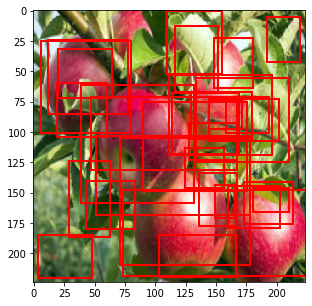

Detected objects:
1) orange
2) banana
3) banana
4) orange
5) banana
6) banana
7) orange
8) orange
9) banana
10) banana
11) orange
12) banana
13) banana
14) orange
15) banana
16) orange
17) banana
18) orange
19) orange
20) banana
21) banana
22) orange
23) banana
24) banana
25) orange
26) orange
27) orange
28) orange
29) banana
30) banana
31) banana
32) orange


In [139]:
scores_threshold = 0.3
filters = [(scores_filter, {"threshold" : scores_threshold})]
visualize_prediction(test_image, prediction, 
                     filters=filters,labels=[_, 'apple', 'orange', 'banana'])

Model makes random predictions

## Task2

### Data

In [140]:
train_dataset = FruitImageDataset(DATASET_PATH, '/train/*.jpg', to_tensor=True)

test_dataset = FruitImageDataset(DATASET_PATH, '/test/*.jpg', to_tensor=True)

train_size = int(len(train_dataset) * train_split_precent)
train_subset, val_subset = random_split(train_dataset, 
                                        [train_size, len(train_dataset) - train_size],
                                        generator=torch.Generator().manual_seed(13))
print(f"Train: {len(train_subset)} | Validation: {len(val_subset)}")

Train: 192 | Validation: 48


In [141]:
batch_size = 16
train_loader = torch.utils.data.DataLoader(train_subset, 
                                           batch_size=batch_size, 
                                           shuffle=False,
                                           collate_fn=collate_fn)

val_loader = torch.utils.data.DataLoader(val_subset, 
                                         batch_size=batch_size, 
                                         shuffle=False,
                                         collate_fn=collate_fn)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False,
                                          collate_fn=collate_fn)

### Unpretrained

In [142]:
num_classes = 4
train_split_precent = 0.8
pretrained = False

Model

In [143]:
frcnn_model_unpretrained = fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=pretrained, pretrained_backbone=True)
prediction_features = frcnn_model_unpretrained.roi_heads.box_predictor.cls_score.in_features
frcnn_model_unpretrained.roi_heads.box_predictor = FastRCNNPredictor(prediction_features, num_classes)

In [144]:
device = "cpu" if not torch.cuda.is_available() else "cuda:0"
_ = frcnn_model_unpretrained.to(device)

In [145]:
device

'cuda:0'

Train

In [146]:
epochs = 10
report_step = 6
params = [p for p in frcnn_model_unpretrained.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.005)

In [147]:
train(frcnn_model_unpretrained, optimizer,
      train_loader, val_loader,
      epochs, report_step,
      checkpoint_path=CHECKPOINTS_PATH + "/fast_rcnn_4_classes_unpretrained")

[ Epoch: 0 | Iteration: 0 | Loss train: 2.3079288005828857 | Eval AUC: 0.0030495621340854463]
[ Epoch: 0 | Iteration: 6 | Loss train: 1.5408647060394287 | Eval AUC: 0.0]
[ Epoch: 1 | Iteration: 12 | Loss train: 1.2710987329483032 | Eval AUC: 0.014783085402774163]
[ Epoch: 1 | Iteration: 18 | Loss train: 1.2055352926254272 | Eval AUC: 0.10920428040509492]
[ Epoch: 2 | Iteration: 24 | Loss train: 1.0800429582595825 | Eval AUC: 0.15064518899873053]
[ Epoch: 2 | Iteration: 30 | Loss train: 0.8531948924064636 | Eval AUC: 0.2216514993468559]
[ Epoch: 3 | Iteration: 36 | Loss train: 0.5459617972373962 | Eval AUC: 0.254654844195767]
[ Epoch: 3 | Iteration: 42 | Loss train: 0.65789794921875 | Eval AUC: 0.2905469237382404]
[ Epoch: 4 | Iteration: 48 | Loss train: 0.6072098612785339 | Eval AUC: 0.49500623751780415]
[ Epoch: 4 | Iteration: 54 | Loss train: 0.5195901989936829 | Eval AUC: 0.5488422597667847]
[ Epoch: 5 | Iteration: 60 | Loss train: 0.47670209407806396 | Eval AUC: 0.4953322214161411]

Evaluation results

In [148]:
evaluate(frcnn_model_unpretrained, test_loader, device)

0.5742597262920395

### Pretrained

In [149]:
num_classes = 4
train_split_precent = 0.8
pretrained = True

Model

In [226]:
frcnn_model_pretrained = fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=pretrained, pretrained_backbone=True)
prediction_features = frcnn_model_pretrained.roi_heads.box_predictor.cls_score.in_features
frcnn_model_pretrained.roi_heads.box_predictor = FastRCNNPredictor(prediction_features, num_classes)

In [227]:
device = "cpu" if not torch.cuda.is_available() else "cuda:0"
_ = frcnn_model_pretrained.to(device)

In [228]:
device

'cuda:0'

Train

In [229]:
epochs = 20
report_step = 6
params = [p for p in frcnn_model_pretrained.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.005)

In [230]:
train(frcnn_model_pretrained, optimizer,
      train_loader, val_loader,
      epochs, report_step,
      checkpoint_path=CHECKPOINTS_PATH + "/fast_rcnn_BEST_pretrained")

[ Epoch: 0 | Iteration: 0 | Loss train: 2.9036338329315186 | Eval AUC: 0.04396135029124108]
[ Epoch: 0 | Iteration: 6 | Loss train: 1.6913155317306519 | Eval AUC: 0.6324364818456844]
[ Epoch: 1 | Iteration: 12 | Loss train: 1.5092593431472778 | Eval AUC: 0.7167712954951162]
[ Epoch: 1 | Iteration: 18 | Loss train: 1.313212513923645 | Eval AUC: 0.7837820370463364]
[ Epoch: 2 | Iteration: 24 | Loss train: 1.193786382675171 | Eval AUC: 0.8325043680161937]
[ Epoch: 2 | Iteration: 30 | Loss train: 0.876388669013977 | Eval AUC: 0.878329941906299]
[ Epoch: 3 | Iteration: 36 | Loss train: 1.0323982238769531 | Eval AUC: 0.8446373191295099]
[ Epoch: 3 | Iteration: 42 | Loss train: 0.8935120701789856 | Eval AUC: 0.842550390927282]
[ Epoch: 4 | Iteration: 48 | Loss train: 0.965188205242157 | Eval AUC: 0.8538415263635593]
[ Epoch: 4 | Iteration: 54 | Loss train: 0.8682477474212646 | Eval AUC: 0.8749506393710135]
[ Epoch: 5 | Iteration: 60 | Loss train: 1.0301157236099243 | Eval AUC: 0.8744974693213

In [232]:
evaluate(frcnn_model_pretrained, test_loader, device)

0.8550877974881292


BEST TEST RESULT AUC: 0.8550877974881292
---

## Task3 + Task4

### IoU Threshold

In [156]:
evaluate(frcnn_model_pretrained, test_loader, device, iou_threshold=0.4)

0.8657912588500134

In [157]:
evaluate(frcnn_model_pretrained, test_loader, device, iou_threshold=0.1)

0.8718800711421156

In [158]:
evaluate(frcnn_model_pretrained, test_loader, device, iou_threshold=0.6)

0.788386651852677

**Conclusion**:  
*less* iou_threshold -> *higher* metric  

---

However, we should not **trust** the results with low iou_threshold

### Scores filtering

In [159]:
scores_threshold = 0.0 # standart
filters = [(scores_filter, {"threshold" : scores_threshold})]
evaluate(frcnn_model_pretrained, test_loader, device, iou_threshold=0.5, filters=filters)

0.8502821779573193

In [160]:
scores_threshold = 0.5
filters = [(scores_filter, {"threshold" : scores_threshold})]
evaluate(frcnn_model_pretrained, test_loader, device, iou_threshold=0.5, filters=filters)

0.7788108246435886

In [161]:
scores_threshold = 0.3
filters = [(scores_filter, {"threshold" : scores_threshold})]
evaluate(frcnn_model_pretrained, test_loader, device, iou_threshold=0.5, filters=filters)

0.8069008385835021

In [162]:
scores_threshold = 0.7
filters = [(scores_filter, {"threshold" : scores_threshold})]
evaluate(frcnn_model_pretrained, test_loader, device, iou_threshold=0.5, filters=filters)

0.7423177566897123

**Conclusion**:  
metrics show, that **limiting** the confidence score leads to **worse metrics** :( 

---

**BUT!!!** Let's try to visualize

### Visualization

In [166]:
labels = [_, 'apple', 'orange', 'banana']

In [167]:
test_image, test_target = test_dataset[0]
frcnn_model_pretrained.eval()
with torch.no_grad():
  prediction = frcnn_model_pretrained([test_image.to(device)])[0]
prediction['scores']

tensor([0.9877, 0.9707, 0.9683, 0.9468, 0.5504, 0.0923], device='cuda:0')

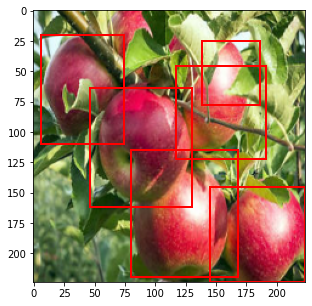

Detected objects:
1) apple
2) apple
3) apple
4) apple
5) apple
6) apple


In [168]:
scores_threshold = 0.0
filters = [(scores_filter, {"threshold" : scores_threshold})]
visualize_prediction(test_image, prediction,
                     filters=filters, labels=labels)

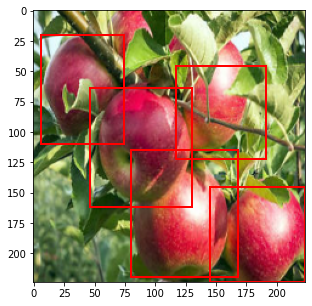

Detected objects:
1) apple
2) apple
3) apple
4) apple
5) apple


In [169]:
scores_threshold = 0.5
filters = [(scores_filter, {"threshold" : scores_threshold})]
visualize_prediction(test_image, prediction,
                     filters=filters, labels=labels)

We can see, that scores filtering helped to exclude **excess frame** in the middle  
This frame doesn't have signinficant influence on metrics, but it detects non-existent object  

In [170]:
test_image, test_target = test_dataset[59]
frcnn_model_pretrained.eval()
with torch.no_grad():
  prediction = frcnn_model_pretrained([test_image.to(device)])[0]
prediction['scores']

tensor([0.9905, 0.9845, 0.8529, 0.4658, 0.0718], device='cuda:0')

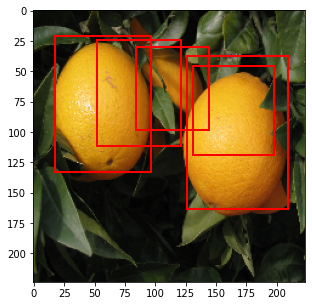

Detected objects:
1) orange
2) orange
3) orange
4) orange
5) orange


In [171]:
scores_threshold = 0.0
filters = [(scores_filter, {"threshold" : scores_threshold})]
visualize_prediction(test_image, prediction,
                     filters=filters, labels=labels)

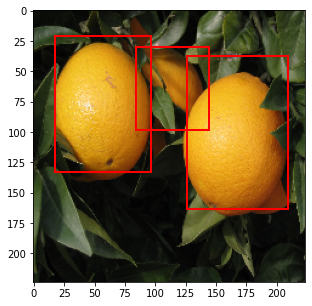

Detected objects:
1) orange
2) orange
3) orange


In [172]:
scores_threshold = 0.5
filters = [(scores_filter, {"threshold" : scores_threshold})]
visualize_prediction(test_image, prediction,
                     filters=filters, labels=labels)

In this situation we filtered well detected lemon by 0.5 threshold  
Bad result


---

**Conclusion**: for better real results we should set score filtering with low threshold, **BUT GREATER THAN FOR 1 CLASS**

In [176]:
scores_threshold = 0.3
filters = [(scores_filter, {"threshold" : scores_threshold})]
evaluate(frcnn_model_pretrained, test_loader, device, iou_threshold=0.5, filters=filters)

0.8069008385835021

### Pictures from the Internet

In [177]:
internet_dataset = FruitImageDataset(DATASET_PATH, filter="/internet/*.jpg", 
                                     to_tensor=True, 
                                     classes=labels,
                                     allow_no_target=True)

In [178]:
test_image, _ = internet_dataset[0]
frcnn_model_pretrained.eval()
with torch.no_grad():
  prediction = frcnn_model_pretrained([test_image.to(device)])[0]
prediction['scores']

tensor([0.4723, 0.2676, 0.2368, 0.0663, 0.0641, 0.0619], device='cuda:0')

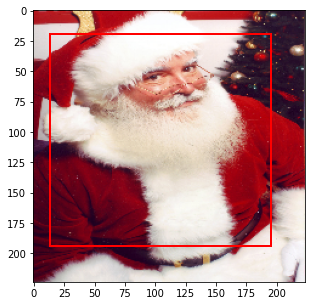

Detected objects:
1) banana


In [181]:
scores_threshold = 0.3
filters = [(scores_filter, {"threshold" : scores_threshold})]
visualize_prediction(test_image, prediction,
                     filters=filters, labels=labels)

In [182]:
test_image, _ = internet_dataset[1]
frcnn_model_pretrained.eval()
with torch.no_grad():
  prediction = frcnn_model_pretrained([test_image.to(device)])[0]
prediction['scores']

tensor([0.9109, 0.8917, 0.8094, 0.7949, 0.7758, 0.7450, 0.7152, 0.7116, 0.6914,
        0.5733, 0.5266, 0.4849, 0.4185, 0.3805, 0.3037, 0.2730, 0.2179, 0.1649,
        0.1613, 0.1326, 0.1325, 0.1273, 0.1232, 0.1230, 0.0950, 0.0929, 0.0870,
        0.0852, 0.0813, 0.0753, 0.0705, 0.0616, 0.0594, 0.0588, 0.0550, 0.0547],
       device='cuda:0')

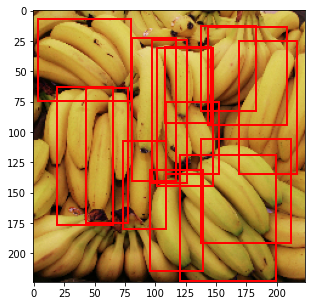

Detected objects:
1) banana
2) banana
3) banana
4) banana
5) banana
6) banana
7) banana
8) banana
9) banana
10) banana
11) banana
12) banana
13) banana
14) banana
15) banana


In [185]:
scores_threshold = 0.3
filters = [(scores_filter, {"threshold" : scores_threshold})]
visualize_prediction(test_image, prediction,
                     filters=filters, labels=labels)

In [186]:
test_image, _ = internet_dataset[2]
frcnn_model_pretrained.eval()
with torch.no_grad():
  prediction = frcnn_model_pretrained([test_image.to(device)])[0]
prediction['scores']

tensor([0.7871, 0.1458, 0.1306, 0.0897], device='cuda:0')

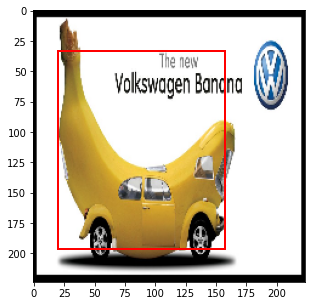

Detected objects:
1) banana


In [189]:
scores_threshold = 0.3
filters = [(scores_filter, {"threshold" : scores_threshold})]
visualize_prediction(test_image, prediction,
                     filters=filters, labels=labels)

In [190]:
test_image, _ = internet_dataset[3]
frcnn_model_pretrained.eval()
with torch.no_grad():
  prediction = frcnn_model_pretrained([test_image.to(device)])[0]
prediction['scores']

tensor([0.8196, 0.2749, 0.1417], device='cuda:0')

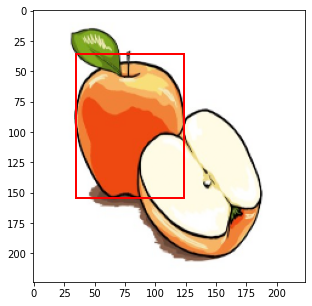

Detected objects:
1) orange


In [193]:
scores_threshold = 0.3
filters = [(scores_filter, {"threshold" : scores_threshold})]
visualize_prediction(test_image, prediction,
                     filters=filters, labels=labels)

Model still think, that Santa hides fruits under his bushy beard  
and it confused yellow apple with an orange (they're really similar)  
But Bananas detection looks really nice

## Task5

In [225]:
nms_threshold = 0.1

filters = [(nms,           {"threshold" : nms_threshold})]
evaluate(frcnn_model_pretrained, test_loader, device, 
         iou_threshold=nms_threshold, filters=filters)

0.7029150397898671

In [224]:
nms_threshold = 0.2

filters = [(nms,           {"threshold" : nms_threshold})]
evaluate(frcnn_model_pretrained, test_loader, device, 
         iou_threshold=nms_threshold, filters=filters)

0.7835025303108144

In [201]:
test_image, test_target = test_dataset[0]
frcnn_model_pretrained.eval()
with torch.no_grad():
  prediction = frcnn_model_pretrained([test_image.to(device)])[0]
prediction['scores']

tensor([0.9877, 0.9707, 0.9683, 0.9468, 0.5504, 0.0923], device='cuda:0')

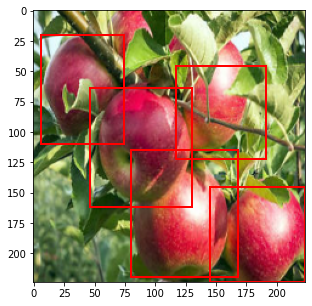

Detected objects:
1) apple
2) apple
3) apple
4) apple
5) apple


In [207]:
nms_threshold = 0.2

filters = [(nms, {"threshold" : nms_threshold})]

visualize_prediction(test_image, prediction,
                     filters=filters, labels=labels)

In [208]:
test_image, _ = internet_dataset[1]
frcnn_model_pretrained.eval()
with torch.no_grad():
  prediction = frcnn_model_pretrained([test_image.to(device)])[0]
prediction['scores']

tensor([0.9109, 0.8917, 0.8094, 0.7949, 0.7758, 0.7450, 0.7152, 0.7116, 0.6914,
        0.5733, 0.5266, 0.4849, 0.4185, 0.3805, 0.3037, 0.2730, 0.2179, 0.1649,
        0.1613, 0.1326, 0.1325, 0.1273, 0.1232, 0.1230, 0.0950, 0.0929, 0.0870,
        0.0852, 0.0813, 0.0753, 0.0705, 0.0616, 0.0594, 0.0588, 0.0550, 0.0547],
       device='cuda:0')

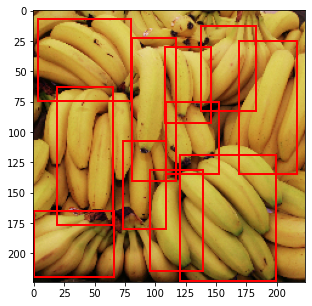

Detected objects:
1) banana
2) banana
3) banana
4) banana
5) banana
6) banana
7) banana
8) banana
9) banana
10) banana
11) banana


In [214]:
nms_threshold = 0.2

filters = [(nms, {"threshold" : nms_threshold})]

visualize_prediction(test_image, prediction,
                     filters=filters, labels=labels)

Despite the decrease in metrics, real results show improvements